In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create project directory in Drive
import os
project_dir = '/content/drive/MyDrive/Fashion_MNIST_Project'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/models', exist_ok=True)
os.makedirs(f'{project_dir}/results', exist_ok=True)

print(f"Project directory created: {project_dir}")

Mounted at /content/drive
Project directory created: /content/drive/MyDrive/Fashion_MNIST_Project


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import classification_report, confusion_matrix
import json

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def load_fashion_mnist():
    """Load Fashion-MNIST from Keras built-in dataset"""
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    # Flatten images for MLP (28x28 -> 784)
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    return X_train, y_train, X_test, y_test

def get_class_names():
    """Fashion-MNIST class names"""
    return ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def preprocess_for_cnn(X_train, X_test, y_train, y_test):
    """Preprocess data for CNN"""
    # Reshape for CNN (28x28x1)
    X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    return X_train, X_test, y_train, y_test

print(" Functions defined successfully")

 Functions defined successfully


In [4]:
# Load data
X_train, y_train, X_test, y_test = load_fashion_mnist()
class_names = get_class_names()

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training data shape: (60000, 784)
Training labels shape: (60000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)
Number of classes: 10
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


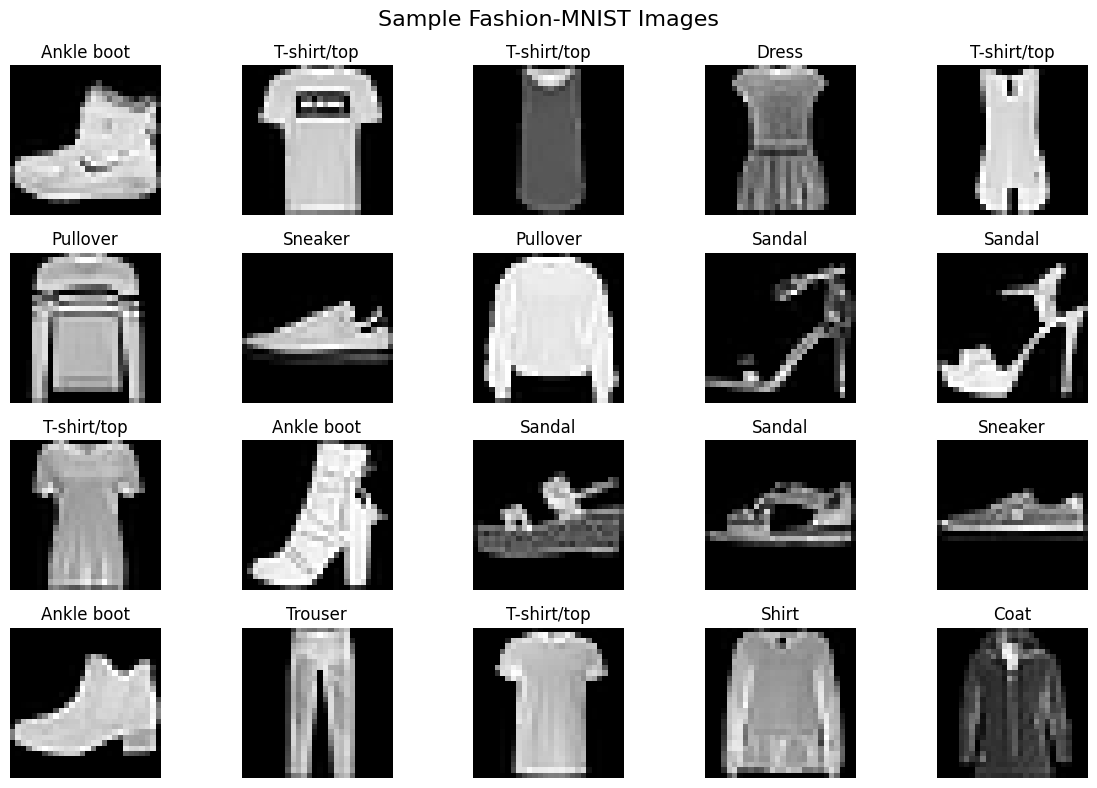

In [5]:
# Visualize sample images
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'{class_names[y_train[i]]}')
    plt.axis('off')
plt.suptitle('Sample Fashion-MNIST Images', fontsize=16)
plt.tight_layout()
plt.savefig(f'{project_dir}/results/sample_images.png')
plt.show()

In [6]:
# Preprocess data for CNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = preprocess_for_cnn(X_train, X_test, y_train, y_test)

print("CNN Preprocessing:")
print(f"Training data shape: {X_train_cnn.shape}")
print(f"Test data shape: {X_test_cnn.shape}")
print(f"Data range: {X_train_cnn.min():.2f} to {X_train_cnn.max():.2f}")

CNN Preprocessing:
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Data range: 0.00 to 1.00


In [7]:
def create_cnn_model():
    """Create CNN model architecture"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and display CNN model
cnn_model = create_cnn_model()
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train CNN model
print("Training CNN Model...")
cnn_history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    epochs=15,
    batch_size=128,
    validation_data=(X_test_cnn, y_test_cnn),
    verbose=1
)

# Evaluate CNN
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"\n✅ CNN Test Accuracy: {cnn_test_acc:.4f} ({cnn_test_acc*100:.2f}%)")

Training CNN Model...
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6544 - loss: 0.9708 - val_accuracy: 0.8416 - val_loss: 0.4345
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8512 - loss: 0.4168 - val_accuracy: 0.8721 - val_loss: 0.3579
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8739 - loss: 0.3531 - val_accuracy: 0.8817 - val_loss: 0.3295
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8870 - loss: 0.3099 - val_accuracy: 0.8743 - val_loss: 0.3358
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8960 - loss: 0.2929 - val_accuracy: 0.8969 - val_loss: 0.2880
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9035 - loss: 0.2673 - val_accuracy: 0.9014 - val_loss: 0.2720
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9109 - loss: 0.2485 - val_accuracy: 0.8961 - val_loss: 0.2806
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9158 - loss: 0

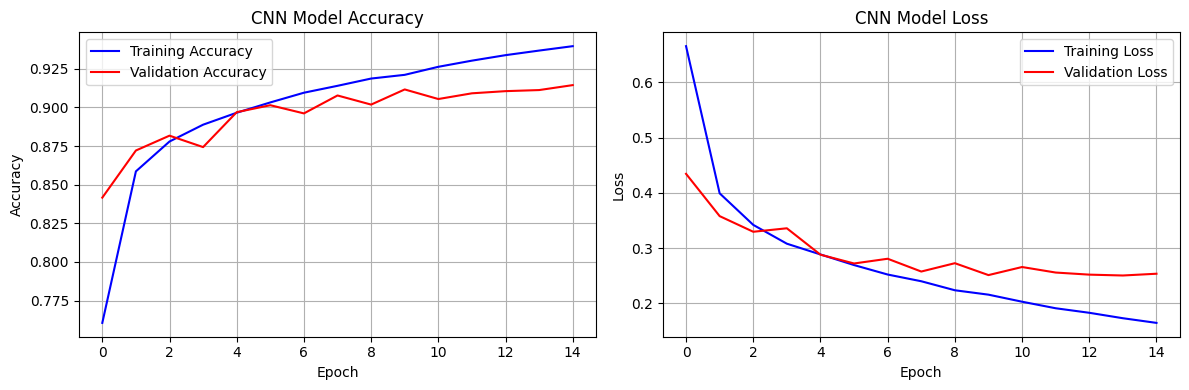

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))

# Training accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Training loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f'{project_dir}/results/training_history.png')
plt.show()

In [10]:
# Get CNN predictions
cnn_predictions = cnn_model.predict(X_test_cnn)
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

# Classification report
print("CNN Classification Report:")
print(classification_report(y_test_cnn, cnn_pred_classes, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
CNN Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.88      0.87      1000
     Trouser       1.00      0.97      0.99      1000
    Pullover       0.84      0.90      0.87      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.85      0.88      0.87      1000
      Sandal       0.96      0.99      0.97      1000
       Shirt       0.81      0.69      0.74      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



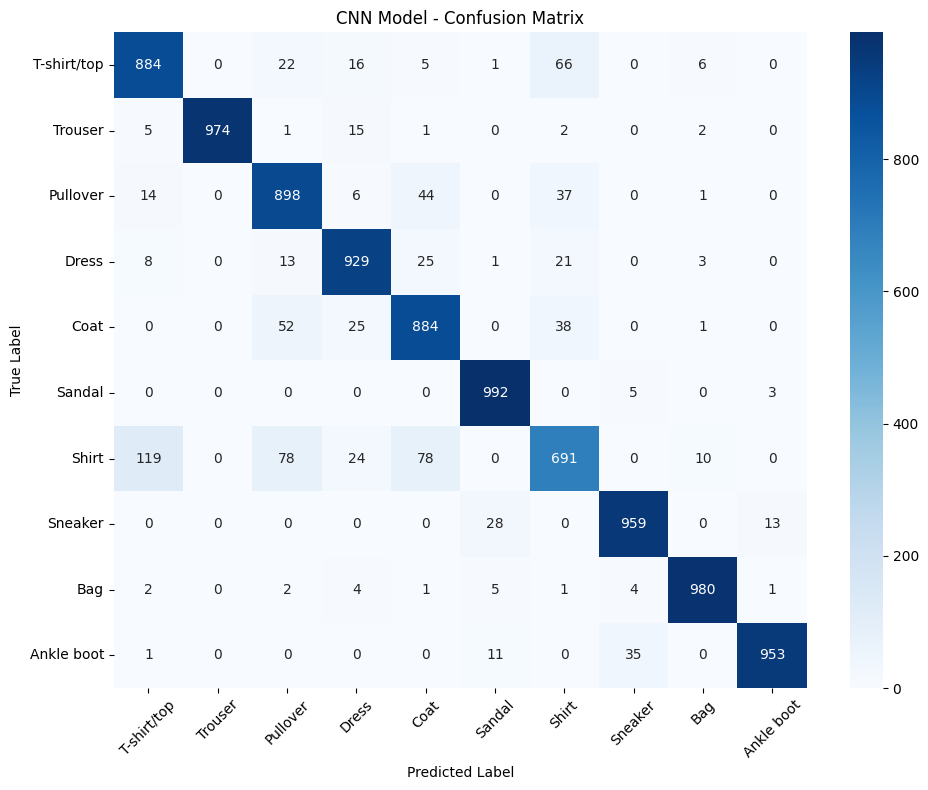

In [11]:
# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_cnn, cnn_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{project_dir}/results/confusion_matrix.png')
plt.show()

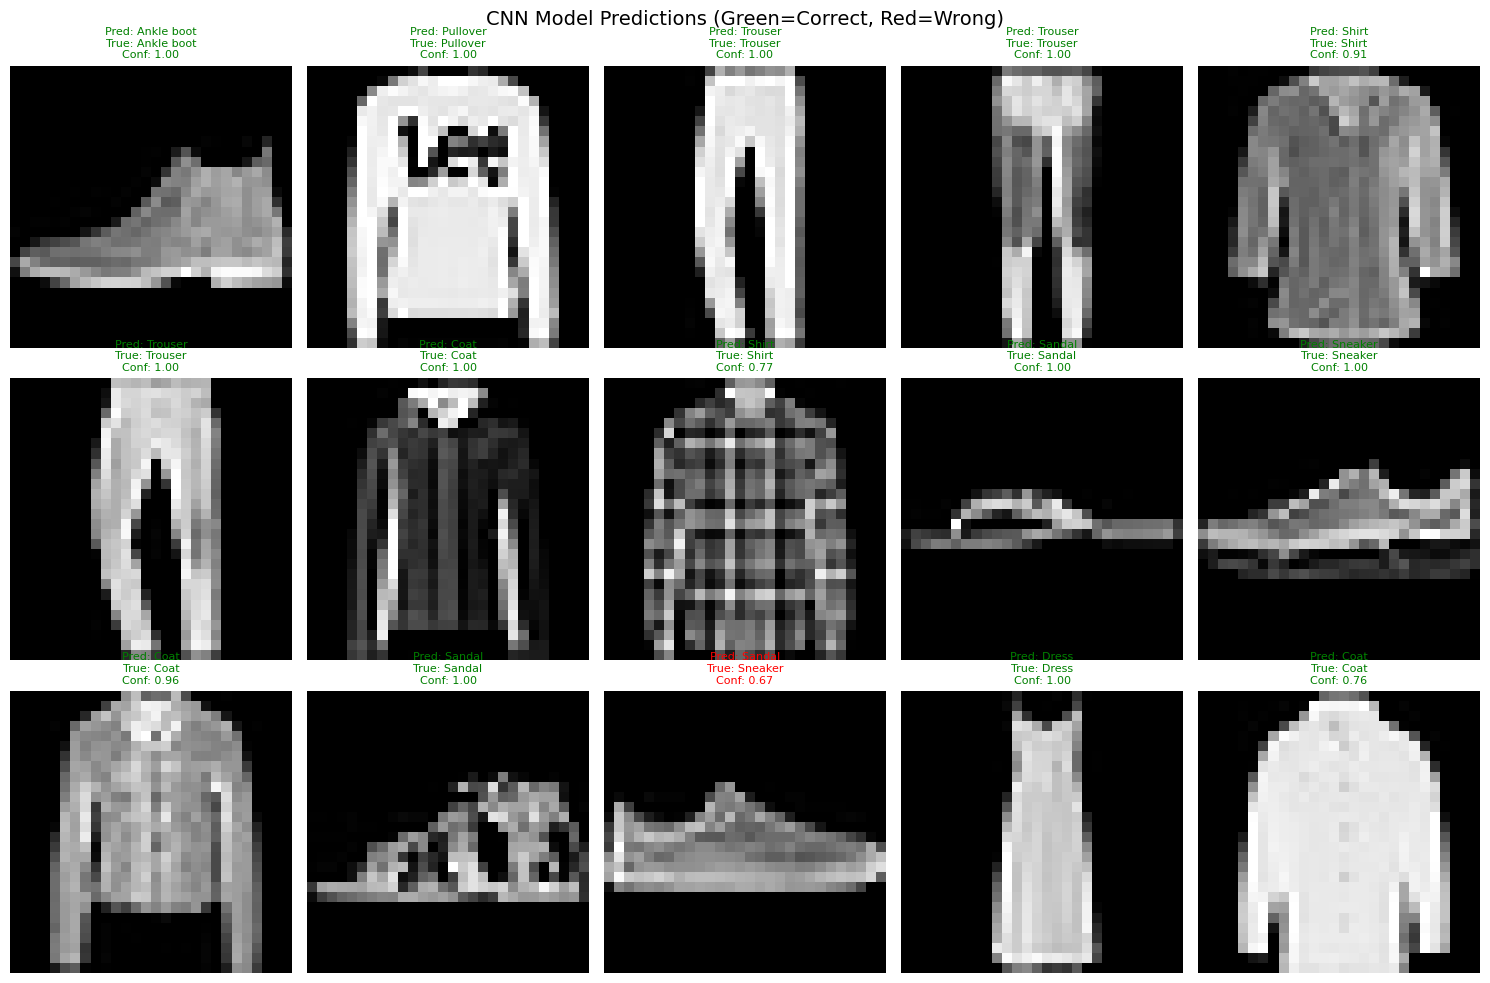

In [12]:
# Show sample predictions
plt.figure(figsize=(15, 10))

num_images = 15
for i in range(num_images):
    plt.subplot(3, 5, i + 1)

    # Show image
    img = X_test_cnn[i].reshape(28, 28)
    plt.imshow(img, cmap='gray')

    # Get prediction
    predicted_class = np.argmax(cnn_predictions[i])
    true_class = y_test_cnn[i]
    confidence = np.max(cnn_predictions[i])

    # Color: green if correct, red if wrong
    color = 'green' if predicted_class == true_class else 'red'

    plt.title(f'Pred: {class_names[predicted_class]}\nTrue: {class_names[true_class]}\nConf: {confidence:.2f}',
             color=color, fontsize=8)
    plt.axis('off')

plt.suptitle('CNN Model Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.savefig(f'{project_dir}/results/sample_predictions.png')
plt.show()

In [13]:
# Save CNN model to Google Drive
model_path = f'{project_dir}/models/cnn_model.h5'
cnn_model.save(model_path)
print(f" CNN model saved to: {model_path}")

# Save training history
history_path = f'{project_dir}/results/training_history.json'
with open(history_path, 'w') as f:
    json.dump(cnn_history.history, f)
print(f" Training history saved to: {history_path}")

# Save results summary
results = {
    'model_type': 'CNN',
    'test_accuracy': float(cnn_test_acc),
    'test_loss': float(cnn_test_loss),
    'epochs': len(cnn_history.history['accuracy']),
    'class_names': class_names,
    'final_train_accuracy': float(cnn_history.history['accuracy'][-1]),
    'final_val_accuracy': float(cnn_history.history['val_accuracy'][-1])
}

results_path = f'{project_dir}/results/model_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f" Results summary saved to: {results_path}")

print("\n" + "="*50)
print(" TRAINING COMPLETE!")
print("="*50)
print(f" Final Test Accuracy: {cnn_test_acc:.4f} ({cnn_test_acc*100:.2f}%)")
print(f" Model saved to Google Drive: {model_path}")
print(f" All results saved to: {project_dir}/results/")
print("="*50)

 CNN model saved to: /content/drive/MyDrive/Fashion_MNIST_Project/models/cnn_model.h5
 Training history saved to: /content/drive/MyDrive/Fashion_MNIST_Project/results/training_history.json
 Results summary saved to: /content/drive/MyDrive/Fashion_MNIST_Project/results/model_results.json

 TRAINING COMPLETE!
 Final Test Accuracy: 0.9144 (91.44%)
 Model saved to Google Drive: /content/drive/MyDrive/Fashion_MNIST_Project/models/cnn_model.h5
 All results saved to: /content/drive/MyDrive/Fashion_MNIST_Project/results/


In [14]:
print(" TO DOWNLOAD YOUR TRAINED MODEL:")
print("1. Go to Google Drive")
print(f"2. Navigate to: MyDrive/Fashion_MNIST_Project/")
print("3. Download the 'models' folder (contains cnn_model.h5)")
print("4. Download the 'results' folder (contains plots and metrics)")
print("\n FILES CREATED:")
print(f"- {project_dir}/models/cnn_model.h5 (trained model)")
print(f"- {project_dir}/results/training_history.json (training metrics)")
print(f"- {project_dir}/results/model_results.json (summary)")
print(f"- {project_dir}/results/*.png (visualization plots)")

# List all created files
import glob
all_files = glob.glob(f'{project_dir}/**/*', recursive=True)
print("\n All created files:")
for file in all_files:
    if os.path.isfile(file):
        print(f"  - {file}")

 TO DOWNLOAD YOUR TRAINED MODEL:
1. Go to Google Drive
2. Navigate to: MyDrive/Fashion_MNIST_Project/
3. Download the 'models' folder (contains cnn_model.h5)
4. Download the 'results' folder (contains plots and metrics)

 FILES CREATED:
- /content/drive/MyDrive/Fashion_MNIST_Project/models/cnn_model.h5 (trained model)
- /content/drive/MyDrive/Fashion_MNIST_Project/results/training_history.json (training metrics)
- /content/drive/MyDrive/Fashion_MNIST_Project/results/model_results.json (summary)
- /content/drive/MyDrive/Fashion_MNIST_Project/results/*.png (visualization plots)

 All created files:
  - /content/drive/MyDrive/Fashion_MNIST_Project/models/cnn_model.h5
  - /content/drive/MyDrive/Fashion_MNIST_Project/results/sample_images.png
  - /content/drive/MyDrive/Fashion_MNIST_Project/results/training_history.png
  - /content/drive/MyDrive/Fashion_MNIST_Project/results/confusion_matrix.png
  - /content/drive/MyDrive/Fashion_MNIST_Project/results/sample_predictions.png
  - /content/dri